<a href="https://colab.research.google.com/github/jocain/Data-444-Project-1/blob/main/Boston_Housing_Locally_Weighted_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Housing Price Prediction Using Locally Weighted Regression

## Joshua O'Cain

In this experiment, we will test the validity of Locally Weighted Regression by comparing the method to Random Forrest Regression using the Boston Housing Dataset. 


In [1]:
%%shell jupyter nbconvert --to html Boston Housing Locally Weighted Regression.ipynb


UsageError: %%shell is a cell magic, but the cell body is empty. Did you mean the line magic %shell (single %)?


In [ ]:
#Standard Imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d, LinearNDInterpolator
import matplotlib.pyplot as plt

# Sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Locally Weighted Regression

Traditional Linear Regression assumes the following model:

$$\large y = X\cdot\beta +\sigma\epsilon $$

In this model, we have some matrix of features $X$ that corralates linearly with a correspoding list of targets $y$ via the vector of coefficients $\beta$. The model assumes some random noise represented by the normal random variable $\epsilon$ scaled by the noise standard deviation vector $\sigma$. To solve for the coefficents $\beta$, we can begin by mulitplying through Equation 1 with the transpose of $X$, $X^T$:

$$\large  X^Ty = X^TX\beta +\sigma X^T\epsilon.$$

Assuming $X^TX$ is invertible, we can then rearrange the equation and say

$$\large \beta = (X^TX)^{-1}(X^Ty) - \sigma (X^TX)^{-1}X^T\epsilon.$$

We now have the coefficients vector $\beta$ as the sum of a linear combination of the observed values and some scaled random noise. Consequentially, the expected value of $\beta$ is 

$$\large \bar{\beta} = (X^TX)^{-1}X^Ty $$

and the predictions of the model $\hat{y}$ are 

$$\large \hat{y} = X(X^TX)^{-1}X^Ty. $$

While this model can work very well in a broad range of applications, there are many situations where relationships are non linear. Locally Weighted Regression uses data points near (local to) a region of interest to make predictions. The result is a model can recognize broad linear trends and that can be adjusted to local distinctions in the data. Locality, in this implementation, is defined by the Euclidean distance between observations. In the features matrix $X$, the row vectors represent individual observations. Therefore, for two row vectors $\vec{v}$ and $\vec{v}$ with $p$ dimensions, the Euclidean distance $d$ is the following:

$$\large d_{(\vec{v},\vec{w})}=\sqrt{(v_1-w_1)^2+(v_2-w_2)^2+...(v_p-w_p)^2}$$

For $n$ observations, each vector will have $n$ corresponding distances. We can therefore create a distance-dependent weighting square matrix $W_k$ for an $k$th observation. $W_k$ has a side length $n$, where the weights occupy the diagonal of the matrix (i.e. $W_{11}$, $W_{22}$, for matrix element $W_{ij}$ of row $i$ and column $j$). All of the rest of the elements are 0. To apply this fix, we multiply $W_kX^T$ through Equation 1 instead of just $X^T$:

$$\large W_ky = W_kX\cdot\beta +\sigma W_k\epsilon. $$

The new expected value of $\beta$ becomes 

$$\large \bar{\beta} = (X^TW_kX)^{-1}X^TW_ky$$

and the new predictions are

$$\large \hat{y} = X(X^TW_kX)^{-1}X^TW_ky.$$

A version of Locally Weighted Regressor Function is inplemented below, using the scipy linalg and interpolate packages to facilitate the linear algebra and data interpolation, respectively. 

In [ ]:
# Locally Weighted Regession Model
def lowess_reg(x, y, xnew, kern, tau, intercept = False):
  if len(x.shape)==1:
    x = x.reshape(-1,1) 
    interpolator = interp1d
  else:
    interpolator = LinearNDInterpolator
  print(x)
  n = len(y) 
  if intercept:
    x = np.column_stack([np.ones(n),x])
  else:
    x = x
  yest = np.zeros(len(y))
  for i in range(n):
    weights = kern((x-x[i])/(2*tau))
    W = np.diag(weights)
    b = W.dot(y)
    A = W.dot(x)
    beta, res, rnk, s = linalg.lstsq(A,b)
    yest[i] = np.dot(x[i],beta)
  f = interpolator(x, yest)
  return f(xnew)

def lowess_reg(x, y, xnew, kern, tau):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)

Note that this implementation includes three hyperparameters not yet mentioned: intercept, kern, and $\tau$ (tau). In the linear model used above, the targets are assumed to have no offset and be centered around 0. If this is not the case, the fix is not particularly difficult - a column vector of value 1 is added to the features matrix. As a result, the predictions will produce the form 

$$\large \hat{y} = \beta_0x_0 + \beta_1x_1 + ... + \beta_nx_n + \beta_{n+1}(1),$$

generating the needed offset. 

kern refers to the kernel used for the model, or the specific function used for weighting. A few possible kernels exist for Locally Weighted Regression models. The Tricubic kernel is the most common:

$$W_{nn} = \frac{70}{81}(1 - d^3)^3$$

In this equation, $d$ is the Euclidean distance. The Tricubic, Quartic, and Epanechnikov kernels are implemented below, and a graph comparing how the weights drop off with distance is shown below. Note that all of the kernels are valid for $0 < d < 1$. Outside of that range, $W_{nn} = 0$.

In [ ]:
# Locally Weighted Regession Functions

# Kernels
def tricubic(x):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    d = np.sqrt(np.sum(x, axis = 1)**2)
    return np.where(d>1,0,70/81*(1-d**3)**3)

def Epanechnikov(x):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    d = np.sqrt(np.sum(x, axis = 1)**2)
    return np.where(d>1,0,3/4*(1-d**2))

def Quartic(x):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    d = np.sqrt(np.sum(x, axis = 1)**2)
    return np.where(d>1,0,15/16*(1-d**2)**2) 


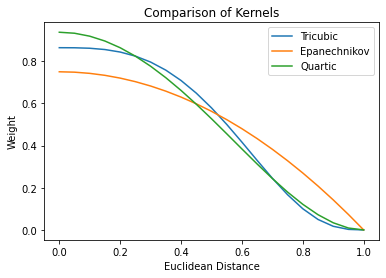

In [ ]:
# Comparison of How Each Kernel Weights the Data
x = np.arange(0, 1.05, 0.05).reshape(-1, 1)
plt.plot(x, tricubic(x), label = 'Tricubic')
plt.plot(x, Epanechnikov(x), label = 'Epanechnikov')
plt.plot(x, Quartic(x), label = 'Quartic')
plt.legend()
plt.title('Comparison of Kernels')
plt.ylabel('Weight')
plt.xlabel('Euclidean Distance')
plt.show()

Finally, hyperparameter $\tau$ the range defined to be "local" in the weighting matrix. $\tau$ is used to scale the Euclidean distance $d$ to $d' = d/(2\tau)$, increasing or decreasing the range of the kernel. In practice, this can affect the smoothness of the predictions. The effect of adjusting $\tau$, and an example of Locally Weighted Regression, is shown below, on a data set containing linear and sinusoidal components. The tricubic kernel is used.


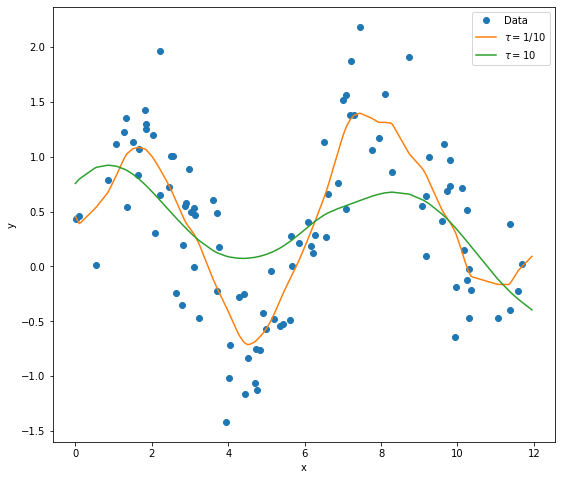

In [ ]:
x = np.random.uniform(0, 12, 100)
y = np.sin(x) + x/12 + np.random.normal(loc=0,scale=.5,size=100)
xnew = np.arange(0, 12, 0.05)

yhat1 = lowess_reg(x, y, xnew, tricubic, 0.5)
yhat2 = lowess_reg(x, y, xnew, tricubic, 2)

plt.figure(figsize = (9, 8))
plt.plot(x, y, 'o', label = 'Data')
plt.plot(xnew, yhat1, label = r'$\tau = 1/10$')
plt.plot(xnew, yhat2, label = r'$\tau = 10$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Random Forest Regression

Like we have asserted with Locally Weighted Regression, Random Forest Regression can be used in possibly nonlinear datasets. Random Forrest Regression is an ensemble method which combines a large series of smaller tree classifiers to make predictions. Prior to training, the data is bootstrapped, so each tree recieves only a small random sample of the data. During training, each tree creates paritions in the data by optimizing a quality called the impurity. Minimizing the impurity at every branch in a tree means shifting the partition in a way that decreases the predictive error. By aggregating the predictions of all of the trees, this type of model can be very useful in both classification and regression regimes. An issue that is particularly dangerous in Random Forest Regression models is a runaway tree depth. Regression is generally reserved for continuous data, where an infinite number of partitions can be drawn, resulting in trees that grow beyond a useful depth. This can result in extremely computationally intensive models, and is a common cause of model overfitting. To prevent this, we will limit the tree depth to 3 in this experiment. An example of a Random Forest Regression is shown below, using 150 trees, applied to the sinusoidal data generated above. 

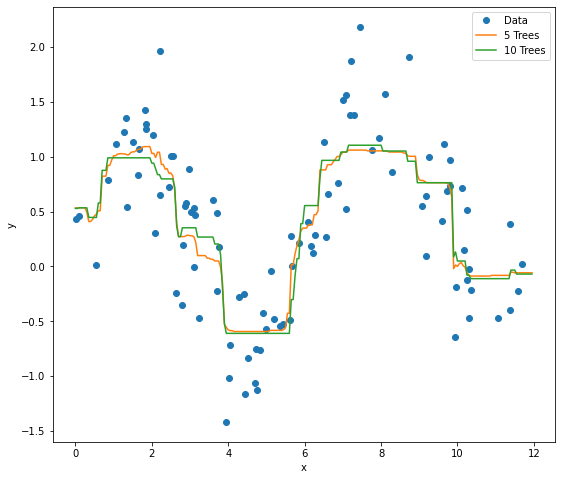

In [ ]:
rf1 = RandomForestRegressor(n_estimators=10,max_depth=3)
rf2 = RandomForestRegressor(n_estimators=100,max_depth=3)

rf1.fit(x.reshape(-1, 1), y)
rf2.fit(x.reshape(-1, 1), y)


yhat3 = rf1.predict(xnew.reshape(-1, 1))
yhat4 = rf2.predict(xnew.reshape(-1, 1))


plt.figure(figsize = (9, 8))
plt.plot(x, y, 'o', label = 'Data')
plt.plot(xnew, yhat4, label = r'5 Trees')
plt.plot(xnew, yhat3, label = r'10 Trees')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

While both methods can resonably create predictions for this dataset, Locally Weighted Regression can have a number of model building advantages over Random Forest Regression. For example, though we are only focused on the number of trees for the Random Forest Regression model, there are a number of other possible hyperparameters to consider, including the minimum number of datapoints per tree split or the impurity function used. Locally Weighted Regression, in contrast, only has one. 

## Methods

The objective of this experiement is to examine the predictive power of Locally Weighted Regression by comparing it to a much more well known and commonly used method, Random Forrest Regression. To do so, we will apply both methods to the Boston Housing Prices dataset. For this experiment, we will consider the number of rooms per house as the dependent variable. The target feature in this experiment will be median house price. To get an precise picture of the model predictive power, the models will undergo a K-Fold validation of 30 splits. For each split, the we will measure the mean squared error on the test set, which we will then average. The averaged MSE will be the statistic used to compare the final models. While a significant difference in the model errors would be definitive evidence towards evidence towards establishing whether a particular model is better, the goal is this project is to estabilsh that Locally Weighted Regression is at least viable. Therefore, viability will be established if the model can score a MSE below 110% of the best Random Forest Regression model. For example, if the best Random Forest Regression produces a MSE of 50, then the Locally Weighted Regression needs to score an MSE no higher than 50. To perform complete investigation of the models, we will generate and test Locally Weighted Regression models with $\tau$ values of 0.01, 0.1, 1, and 10. Additionally, we will create and test Random Forest Regression models with 10, 50, 100, and 300 trees.  This process is implemented below. 

In [ ]:
#Reading in the Data
df = pd.read_csv('/content/drive/MyDrive/DATA 410/Boston Housing Prices.csv')
df.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


In [ ]:
# Setting Features and Targets
y = df['cmedv'].values
x = df['rooms'].values

#Creating Models and Scalars
scaler = StandardScaler()

tau = [0.01, 0.1, 1, 10]

rf1 = RandomForestRegressor(n_estimators=10,max_depth=3)
rf2 = RandomForestRegressor(n_estimators=50,max_depth=3)
rf3 = RandomForestRegressor(n_estimators=100,max_depth=3)
rf4 = RandomForestRegressor(n_estimators=300,max_depth=3)
rfmodels = [rf1, rf1, rf3, rf4]
trees = [10, 50, 100, 300]

In [ ]:
# K-Fold Cross Validation (Training and Predicting)
mse_lwr = [[], [], [], []]
mse_rf = [[], [], [], []]


kf = KFold(n_splits=50,shuffle=True,random_state=410)
for idxtrain,idxtest in kf.split(x):
  ytrain = y[idxtrain]
  xtrain = x[idxtrain]
  xtrain = scaler.fit_transform(xtrain.reshape(-1,1))
  ytest = y[idxtest]
  xtest = x[idxtest]
  xtest = scaler.transform(xtest.reshape(-1,1))

  for i in range(len(tau)):
    yhat_lwr = lowess_reg(xtrain.ravel(),ytrain,xtest.ravel(),tricubic,tau[i])
    mse_lwr[i].append(mse(ytest,yhat_lwr))

  for i in range(len(rfmodels)):
    rfmodels[i].fit(xtrain,ytrain)
    yhat_rf = rfmodels[i].predict(xtest)
    mse_rf[i].append(mse(ytest,yhat_rf))


The results of the Locally Weighted Regression are posted below, followed by the results of the Random Forest Regressor. Both tables show the average MSE for each model over the 30 fold cross-validation.

In [ ]:
lwr_dict = {'Tau':tau, 'Mean MSE':np.mean(mse_lwr, axis = 1)}
lwr_df = pd.DataFrame(lwr_dict)
lwr_df




,Tau,Mean MSE
0,0.01,44.004721
1,0.10,35.338893
2,1.00,37.099321
3,10.00,43.976500


In [ ]:
rf_dict = {'# Trees':trees, 'Mean MSE':np.mean(mse_rf, axis = 1)}
rf_df = pd.DataFrame(rf_dict)
rf_df

,# Trees,Mean MSE
0,10,36.517983
1,50,35.725301
2,100,35.967733
3,300,35.930195


## Results and Conclusions


In this experiment, we attempted to test the validity of Locally Weighted Regression by comparing the method to Random Forrest Regression using the Boston Housing Dataset. To perform a complete search, we tested Locally Weighted Regressor Models with $\tau$ values of 0.01, 0.1, 1, 10 and Random Forest Regressor Models with 10, 50, 100, and 300 trees. Though there was some improvement between the 10 and 50 tree model, there was very little difference in the models. The 50 tree model performed the best, with a mean MSE of 35.72. Comparatively, adjustment of $\tau$ in the Locally Weighted Regression models had a much greater effect on the final accuracies. Though only slightly, the best Locally Weighted Regression model, the $\tau = 1$ model slightly edged out the best Random Forest Regression Model, with a MSE of 35.33. Because of the evident high dependence of MSE on the $\tau$ value, it is likely the model can be further optimized. However, because further optimization of the Random Forest Regressor model is unlikely, and because a Locally Weighted Regression model outperformed the best Random Forest Regression Model, we have established that the Locally Weighted Regression model is a viable method of attempting nonlinear regression. 

Further work in testing the viablility of Locally Weighted Regression could involve testing the different possible kernels. Additionally, we should note that though we considered Random Forest Regression model size (in the form of number of trees), there are many other parameters that could be adjusted to possibly create a better model. In a professional setting, a much more intensive investigation of these options would be necessary to prove that we have the best possible model. 